In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *

#import pydicom
#!pip install -qU python-gdcm pydicom pylibjpeg

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In this notebook lets take a look at different techniques to handle data imbalance.

In [2]:
df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [7]:
df['filepath'] = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_512/train_images_processed_512/' + df['patient_id'].astype(str) + '/' + df['image_id'].astype(str) + '.png'
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,filepath
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-mammography-images-as-pngs/...


In [8]:
df.iloc[0,-1]

'/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_512/train_images_processed_512/10006/462822612.png'

In [9]:
df = df[['filepath', 'cancer']]
df.head()

,filepath,cancer
0,/kaggle/input/rsna-mammography-images-as-pngs/...,0
1,/kaggle/input/rsna-mammography-images-as-pngs/...,0
2,/kaggle/input/rsna-mammography-images-as-pngs/...,0
3,/kaggle/input/rsna-mammography-images-as-pngs/...,0
4,/kaggle/input/rsna-mammography-images-as-pngs/...,0


In [12]:
df.cancer.value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

### Undersampling

In [14]:
# Class count
count_class_0, count_class_1 = df.cancer.value_counts()

# Divide by class
df_class_0 = df[df['cancer'] == 0]
df_class_1 = df[df['cancer'] == 1]

In [17]:
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under = df_class_0.sample(count_class_1, random_state=1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.cancer.value_counts())

Random under-sampling:
0    1158
1    1158
Name: cancer, dtype: int64


In [18]:
df_test_under.head()

,filepath,cancer
38182,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_512/train_images_processed_512/50994/799654229.png,0
11895,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_512/train_images_processed_512/22706/1838448164.png,0
38810,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_512/train_images_processed_512/51875/1763503482.png,0
12636,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_512/train_images_processed_512/23467/1009349413.png,0
39664,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_512/train_images_processed_512/52873/457185009.png,0


In [19]:
df_test_under.shape

(2316, 2)

In [29]:
# from sklearn.model_selection import train_test_split

# # Split the dataframe into train and test sets
# train_df, test_df = train_test_split(df_test_under, test_size=0.2, stratify=df_test_under.cancer)

In [30]:
db = DataBlock(blocks=(ImageBlock(), CategoryBlock),
                   get_x=lambda x:x[0],
                   get_y=lambda x:x[1],
                   splitter  = RandomSplitter())

dls = db.dataloaders(df_test_under.values, num_workers=0)

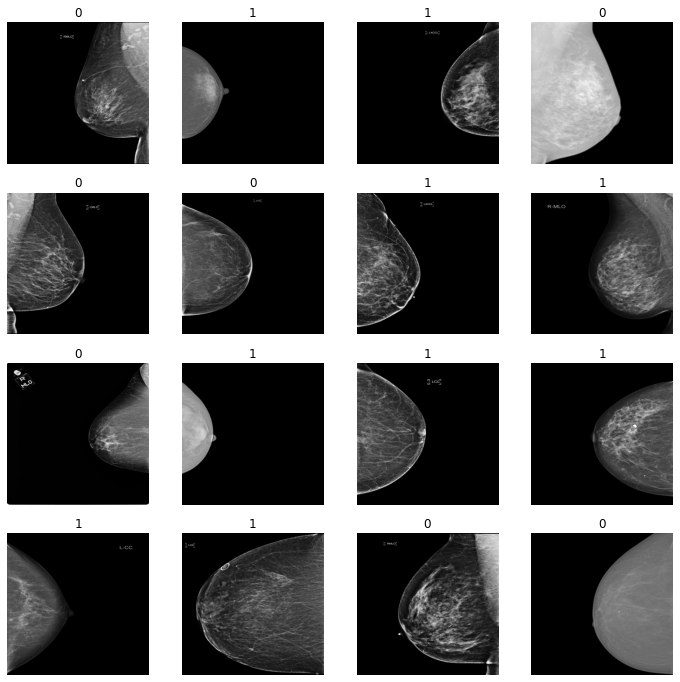

In [31]:
#dls = db.dataloaders(df.values)
dls.show_batch(max_n=16)

In [ ]:
#learn = vision_learner(dls, resnet34, metrics=accuracy)
learn = vision_learner(dls, resnet18, metrics=error_rate, pretrained=False)

In [ ]:
learn.loss_func

In [ ]:
learn.opt_func

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1)

In [ ]:
#learn.save('xresnet18_save', with_opt=False)

In [ ]:
#learn.load('xresnet50_save')

In [ ]:
temp = learn.predict('/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_dicomsdl_256/train_images_processed_cv2_dicomsdl_256/10006/1459541791.png')
temp[0]

In [ ]:
dls.valid_ds

In [ ]:
test_csv = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')

In [ ]:
test_csv.head()

In [ ]:
image_dir_dicomsdl = '/kaggle/working/png_file_dic/'

os.makedirs(image_dir_dicomsdl, exist_ok=True)

#IMAGES_TO_PROCESS = 500

In [ ]:
test_images = glob.glob("/kaggle/input/rsna-breast-cancer-detection/test_images/*/*.dcm")
len(test_images)

In [ ]:
test_images[0]

In [ ]:
def process(f, size=256, save_folder=None, extension="png"):
    
    patient = f.split('/')[-2]
    image_name = f.split('/')[-1][:-4]
    
    dicom = dicoml.open(f)
    img = dicom.pixelData()

    img = (img - img.min()) / (img.max() - img.min())

    if dicom.getPixelDataInfo()['PhotometricInterpretation'] == "MONOCHROME1":
        img = 1 - img

    image = (img * 255).astype(np.uint8)
    
    img = cv2.resize(image, (size, size))

    file_name = f'{save_folder}' + f"{patient}_{image_name}.{extension}"

    cv2.imwrite(file_name, img)

In [ ]:
!pip install /kaggle/input/dicomsdl-offline-installer/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl

In [ ]:
import dicomsdl as dicoml
import cv2
import pydicom

from joblib import Parallel, delayed
import glob
import time
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm import tqdm

In [ ]:
Parallel(n_jobs=4)(
    delayed(process)(f, size = 256, save_folder = image_dir_dicomsdl)
    for f in test_images
)

In [ ]:
prediction_ids = []
preds = []

for _, row in test_csv.iterrows():
    prediction_ids.append(row.prediction_id)
    pred_image_path = image_dir_dicomsdl + str(row.patient_id) + '_' + str(row.image_id) + '.png'
    pred = learn.predict(pred_image_path)[0]
    preds.append(pred)

submission = pd.DataFrame(data={'prediction_id': prediction_ids, 'cancer': preds}).groupby('prediction_id').max().reset_index()
submission.head()

In [ ]:
!rm -r png_file_dic

In [ ]:
!rm -r models

In [ ]:
submission.to_csv('submission.csv', index=False)